# Proyecto: Predicci√≥n de Alertas T√©rmicas mediante Aprendizaje Autom√°tico

Alumno: Mariano Buet

Se propone desarrollar un modelo de clasificaci√≥n multiclase que prediga tres tipos de estados t√©rmicos ‚Äîriesgo de helada, clima de confort y riesgo de sobrecalor‚Äî a partir de variables meteorol√≥gicas.
El objetivo principal es anticipar condiciones extremas para apoyar la toma de decisiones preventivas en distintos √°mbitos: agr√≠cola (proteger cultivos), dom√©stico (evitar congelamiento de ca√±er√≠as) e industrial (ajustar sistemas de ventilaci√≥n o riego)

In [86]:
# Librer√≠as principales
import pandas as pd
import numpy as np

# Visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
# Leer el archivo Excel directamente desde GitHub
url = "https://github.com/MarianoBuet/Aprendizaje-Autom-tico/raw/main/Entregas_Parcial/datos/Estad%C3%ADsticas%20normales%20Datos%20abiertos%201991-2020%20-%20AJUSTADO.xlsx"

df = pd.read_excel(url,header=0)
# Mostrar las primeras filas
df.head()

Estacion  Mes  Dias de Lluvia  Humeda  Nubosidad  Precipitacion  \
0  AEROPARQUE AERO  Ene             6.7    67.0        3.1          117.5   
1  AEROPARQUE AERO  Feb             6.0    69.8        3.2          112.3   
2  AEROPARQUE AERO  Mar             5.9    71.3        3.1          111.8   
3  AEROPARQUE AERO  Abr             6.6    73.6        3.5          108.3   
4  AEROPARQUE AERO  May             5.0    76.4        4.0           83.3   

   Temp Media  Temp Max  Temp Min  Viento Objetivo  
0        24.5      28.4      20.8    16.8   NORMAL  
1        23.7      27.3      20.2    15.8   NORMAL  
2        22.0      25.5      18.8    14.9   NORMAL  
3        18.5      22.0      15.3    13.9   NORMAL  
4        15.2      18.4      12.3    12.9   NORMAL

# Analisis General del Set de Datos

Estructura General y tipos de variables

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Estacion        1171 non-null   object 
 1   Mes             1171 non-null   object 
 2   Dias de Lluvia  1061 non-null   float64
 3   Humeda          1110 non-null   float64
 4   Nubosidad       1166 non-null   float64
 5   Precipitacion   1061 non-null   float64
 6   Temp Media      1167 non-null   float64
 7   Temp Max        1158 non-null   float64
 8   Temp Min        1124 non-null   float64
 9   Viento          708 non-null    float64
 10  Objetivo        1171 non-null   object 
dtypes: float64(8), object(3)
memory usage: 100.8+ KB


Analisis de los valores nulos

In [89]:
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
Estacion            0
Mes                 0
Dias de Lluvia    110
Humeda             61
Nubosidad           5
Precipitacion     110
Temp Media          4
Temp Max           13
Temp Min           47
Viento            463
Objetivo            0
dtype: int64


Analisis Estad√≠stico Rapido

In [90]:
display(df.describe(percentiles=[0.25,0.5,0.75]).T)

count       mean        std   min     25%   50%    75%    max
Dias de Lluvia  1061.0   5.097455   2.536586   0.0   3.100   5.2    7.0   13.8
Humeda          1110.0  68.005405  11.027475  25.7  61.325  70.1   76.4   90.2
Nubosidad       1166.0   3.840137   0.888284   1.3   3.300   3.7    4.2    7.5
Precipitacion   1061.0  68.234873  51.674519   0.0  23.300  58.9  106.5  277.9
Temp Media      1167.0  14.834190   8.178787 -20.9  10.300  15.7   21.2   28.3
Temp Max        1158.0  21.223834   8.938676 -17.5  17.025  22.4   27.9   35.5
Temp Min        1124.0   9.102847   7.778743 -25.0   4.500   9.9   15.1   22.5
Viento           708.0  13.011582   5.554040   3.9   9.200  11.8   15.9   36.5

Analisis de las variables num√©ricas

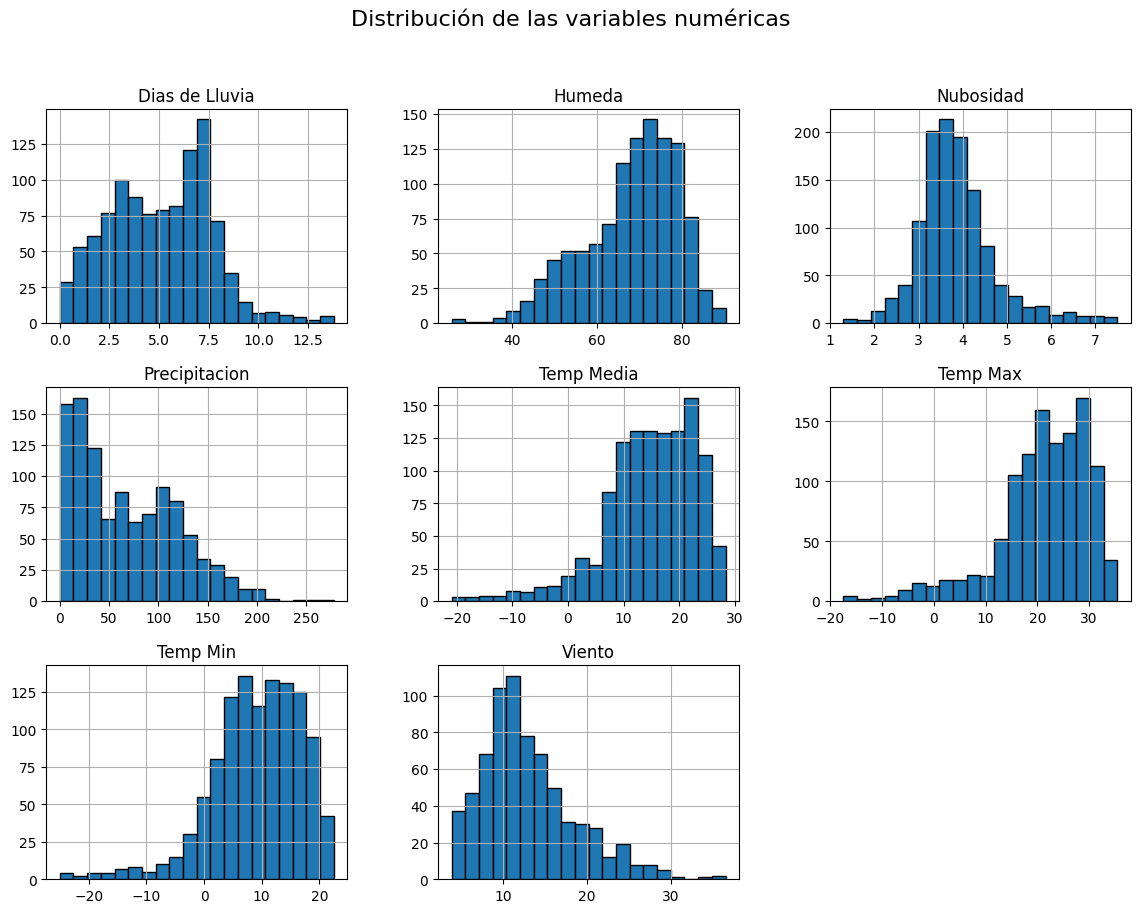

In [91]:
variables_numericas = df.select_dtypes(include=['float64', 'int64']).columns

df[variables_numericas].hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.suptitle("Distribuci√≥n de las variables num√©ricas", fontsize=16)
plt.show()

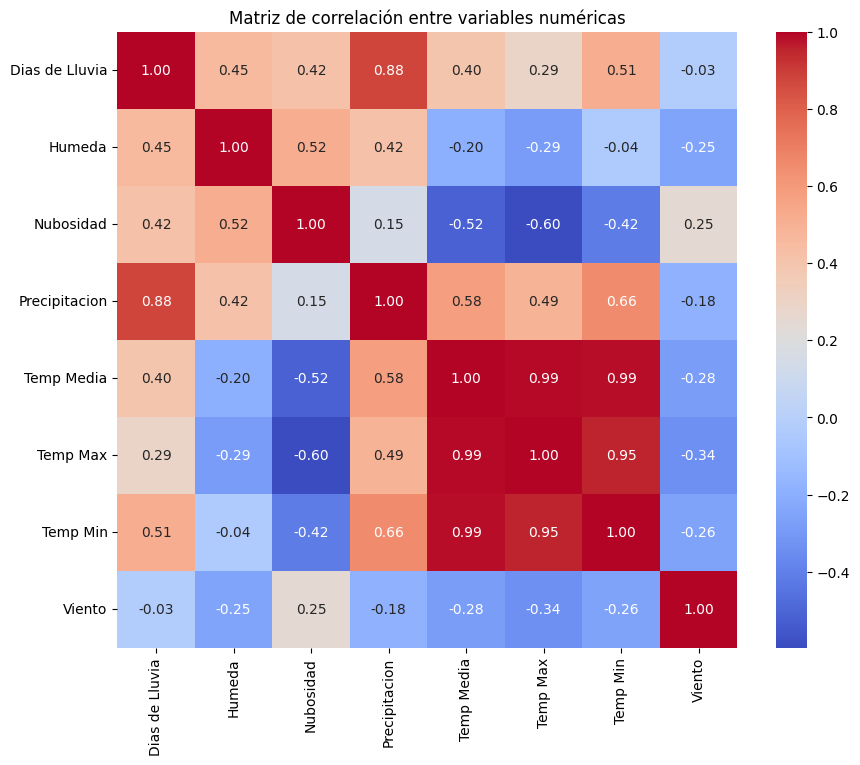

In [92]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[variables_numericas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlaci√≥n entre variables num√©ricas")
plt.show()

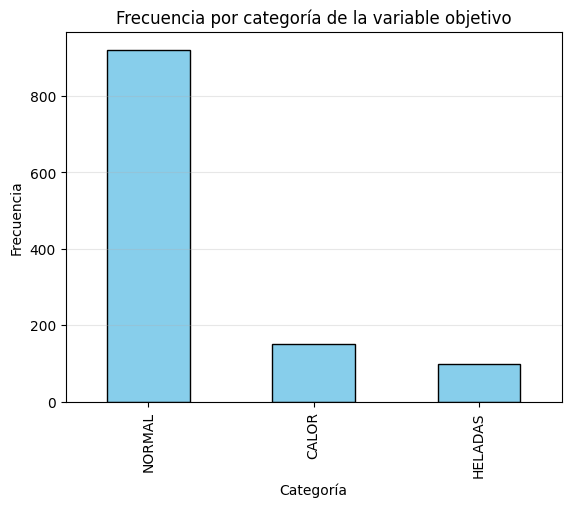

In [93]:
#Visualizar con un histograma la distribucion de la variable objetivo

df['Objetivo'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frecuencia por categor√≠a de la variable objetivo')
plt.xlabel('Categor√≠a')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [94]:
#  Mostrar columnas con valores nulos
faltantes = df.isnull().sum()
faltantes = faltantes[faltantes > 0]

if faltantes.empty:
    print("‚úÖ No hay valores nulos en el dataset.")
else:
    print("üìä Columnas con valores nulos:")
    display(faltantes)

#  Definir manualmente qu√© columnas usar√°n cada m√©todo


#Columnas que usaran la media
cols_media = ['Temp Media','Viento','Dias de Lluvia']

#Columnas que usaran la mediana
cols_mediana = ['Humeda','Precipitacion']

#Columnas que usaran Moda
cols_moda = ['Temp Min', 'Temp Max','Nubosidad']

#Aplicar Media
for col in cols_media:
    if col in df.columns:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)
        print(f"‚úÖ Columna '{col}' completada con la MEDIA ({mean_value:.2f})")
    else:
        print(f"‚ö†Ô∏è La columna '{col}' no existe en el dataset")

# Aplicar Mediana
for col in cols_mediana:
    if col in df.columns:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"‚úÖ Columna '{col}' completada con la MEDIANA ({median_value:.2f})")
    else:
        print(f"‚ö†Ô∏è La columna '{col}' no existe en el dataset")

# 5Ô∏è‚É£ Aplicar Opci√≥n 3 (moda)
for col in cols_moda:
    if col in df.columns:
        moda_series = df[col].mode(dropna=True)
        if len(moda_series) > 0:
            moda_val = moda_series.iloc[0]
            df[col].fillna(moda_val, inplace=True)
            print(f"‚úÖ Columna '{col}' completada con la MODA ({moda_val})")
        else:
            print(f"‚ö†Ô∏è Columna '{col}' no tiene suficiente informaci√≥n para calcular la moda")
    else:
        print(f"‚ö†Ô∏è La columna '{col}' no existe en el dataset")

# 6Ô∏è‚É£ Verificaci√≥n final
faltantes_final = df.isnull().sum()
if faltantes_final.sum() == 0:
    print("\nüéâ Todas las columnas quedaron completas, sin valores nulos.")
else:
    print("\n‚ö†Ô∏è A√∫n quedan valores nulos en las siguientes columnas:")
    print(faltantes_final[faltantes_final > 0])

üìä Columnas con valores nulos:


Dias de Lluvia    110
Humeda             61
Nubosidad           5
Precipitacion     110
Temp Media          4
Temp Max           13
Temp Min           47
Viento            463
dtype: int64

‚úÖ Columna 'Temp Media' completada con la MEDIA (14.83)
‚úÖ Columna 'Viento' completada con la MEDIA (13.01)
‚úÖ Columna 'Dias de Lluvia' completada con la MEDIA (5.10)
‚úÖ Columna 'Humeda' completada con la MEDIANA (70.10)
‚úÖ Columna 'Precipitacion' completada con la MEDIANA (58.90)
‚úÖ Columna 'Temp Min' completada con la MODA (4.9)
‚úÖ Columna 'Temp Max' completada con la MODA (27.9)
‚úÖ Columna 'Nubosidad' completada con la MODA (3.7)

üéâ Todas las columnas quedaron completas, sin valores nulos.


/tmp/ipython-input-3370797599.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)
/tmp/ipython-input-3370797599.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [95]:
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
Estacion          0
Mes               0
Dias de Lluvia    0
Humeda            0
Nubosidad         0
Precipitacion     0
Temp Media        0
Temp Max          0
Temp Min          0
Viento            0
Objetivo          0
dtype: int64


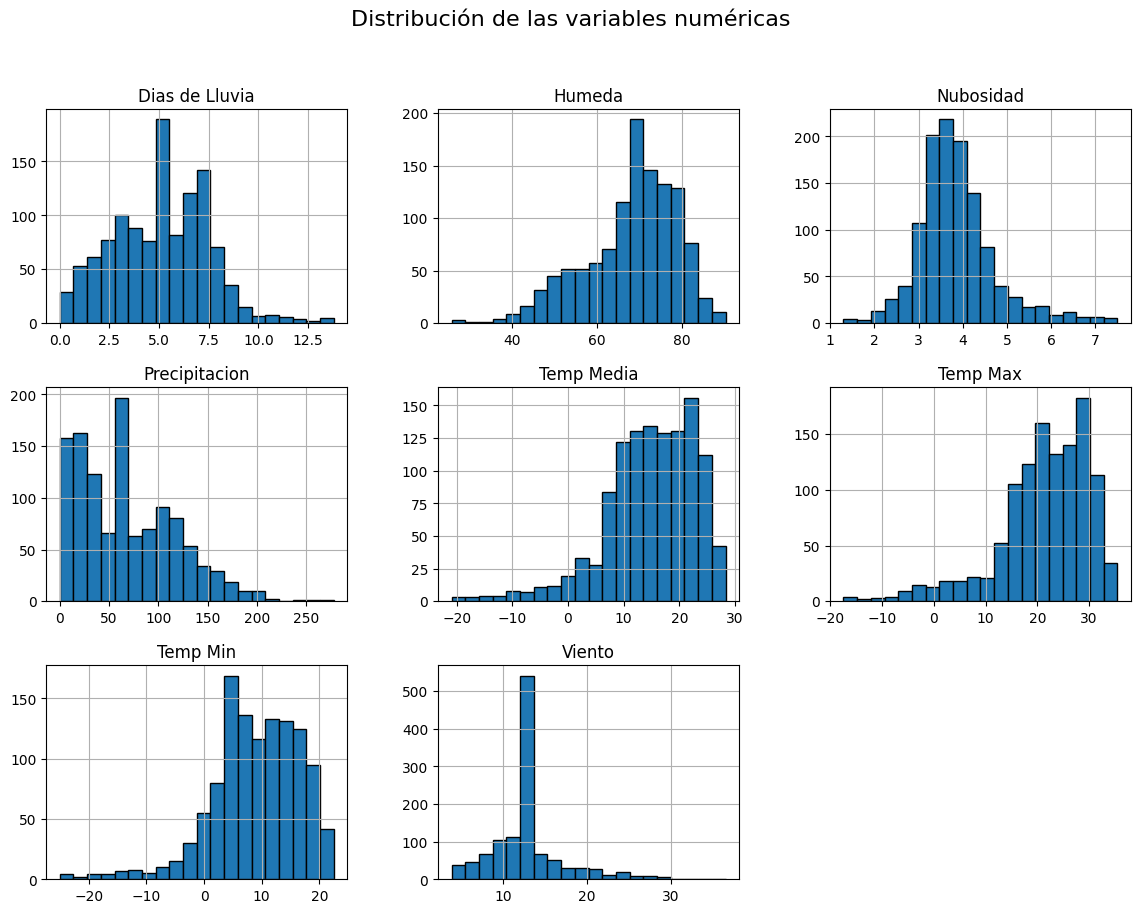

In [96]:
variables_numericas = df.select_dtypes(include=['float64', 'int64']).columns

df[variables_numericas].hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.suptitle("Distribuci√≥n de las variables num√©ricas", fontsize=16)
plt.show()

# Divisi√≥n del dataset en Entrenamiento y Test

In [97]:

from sklearn.model_selection import train_test_split


X = df.drop(columns=['Objetivo']) #Aca qyeda el set de datos sin la variable objetivo, solo las predictoctoras
y = df['Objetivo']

# Divisi√≥n en conjuntos de entrenamiento (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42,stratify=y) #stratify mantiene las proporciones de la distribucion

# Confirmar tama√±os
print("‚úÖ Divisi√≥n completada:")
print(f"Entrenamiento: {X_train.shape[0]} filas ({X_train.shape[1]} variables)")
print(f"Test:          {X_test.shape[0]} filas ({X_test.shape[1]} variables)")

# Verificar distribuci√≥n de clases
print("\nDistribuci√≥n de clases en Entrenamiento:")
print(y_train.value_counts(normalize=True).round(3))

print("\nDistribuci√≥n de clases en Test:")
print(y_test.value_counts(normalize=True).round(3))

‚úÖ Divisi√≥n completada:
Entrenamiento: 936 filas (10 variables)
Test:          235 filas (10 variables)

Distribuci√≥n de clases en Entrenamiento:
Objetivo
NORMAL     0.786
CALOR      0.130
HELADAS    0.083
Name: proportion, dtype: float64

Distribuci√≥n de clases en Test:
Objetivo
NORMAL     0.787
CALOR      0.128
HELADAS    0.085
Name: proportion, dtype: float64


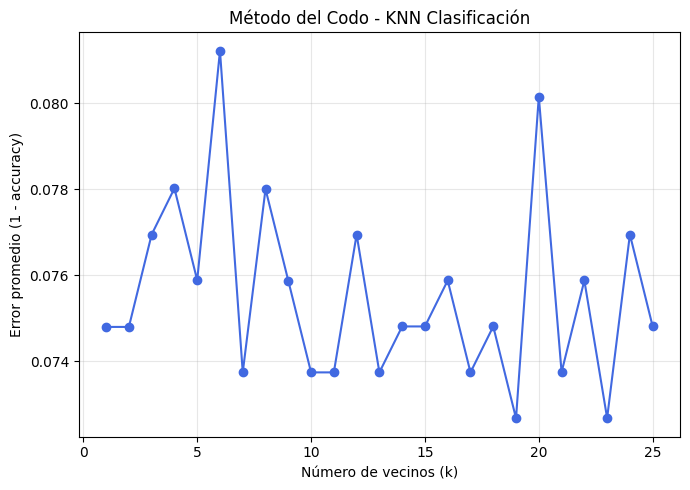

üèÅ K √≥ptimo seg√∫n m√©todo del codo: 19


In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1Ô∏è‚É£ Usamos solo variables num√©ricas
num_cols = X_train.select_dtypes(include=[np.number]).columns
Xtr = X_train[num_cols].copy()
Xte = X_test[num_cols].copy()

# 2Ô∏è‚É£ Escalado (recomendado para KNN)
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

# 3Ô∏è‚É£ Definir rango de k
ks = range(1, 26)   # probamos k de 1 a 25
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4Ô∏è‚É£ Calcular error medio (1 - accuracy) en CV
error_mean = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2)
    scores = cross_val_score(knn, Xtr_s, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    error_mean.append(1 - scores.mean())

# 5Ô∏è‚É£ Graficar m√©todo del codo
plt.figure(figsize=(7,5))
plt.plot(ks, error_mean, marker='o', linestyle='-', color='royalblue')
plt.title('M√©todo del Codo - KNN Clasificaci√≥n')
plt.xlabel('N√∫mero de vecinos (k)')
plt.ylabel('Error promedio (1 - accuracy)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6Ô∏è‚É£ Mostrar el K con menor error
best_k = ks[int(np.argmin(error_mean))]
print(f"üèÅ K √≥ptimo seg√∫n m√©todo del codo: {best_k}")

=== Reporte de Clasificaci√≥n (TEST) ===
              precision    recall  f1-score   support

       CALOR      0.808     0.700     0.750        30
     HELADAS      0.947     0.900     0.923        20
      NORMAL      0.942     0.968     0.955       185

    accuracy                          0.928       235
   macro avg      0.899     0.856     0.876       235
weighted avg      0.925     0.928     0.926       235



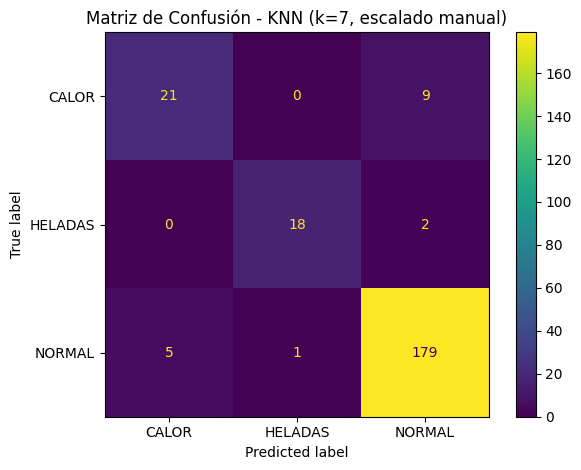

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

num_cols = X_train.select_dtypes(include=[np.number]).columns
Xtr = X_train[num_cols].copy()
Xte = X_test[num_cols].copy()

# Escalado MANUAL
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

# KNN (suele rendir mejor con weights='distance')
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2)
knn.fit(Xtr_s, y_train)

y_pred = knn.predict(Xte_s)
print("=== Reporte de Clasificaci√≥n (TEST) ===")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
disp.plot(values_format="d")
plt.title("Matriz de Confusi√≥n - KNN (k=7, escalado manual)")
plt.tight_layout()
plt.show()